# Telecom Churn Prediction 

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

The goal is to analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

By:

- kamran shaikh 
- kamil shaikh 

In [1]:
# lets import the required libraries and packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# lets import the dataset
telecom = pd.read_csv('telecom_churn_data.csv')
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
# lets check the dimensions of the dataset
telecom.shape

(99999, 226)

# High Value Customers

High-value customers : Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)

lets find out total amount spent by customers on data recharge,we have two colums available to find this out, first column is av_rech_amt_data_x (x represents month here, would be either 6 or 7 or 8), second column is total_rech_data_x (x represnts month here, would be either 6 or 7 or 8)

In [4]:
# lets introduce a new column total_rech_data_amt_x which can be calculated as av_rech_amt_data_x * total_rech_data_x

telecom['total_rech_data_amt_6'] = telecom['av_rech_amt_data_6'] * telecom['total_rech_data_6']
telecom['total_rech_data_amt_7'] = telecom['av_rech_amt_data_7'] * telecom['total_rech_data_7']
telecom['total_rech_data_amt_8'] = telecom['av_rech_amt_data_8'] * telecom['total_rech_data_8']
telecom['total_rech_data_amt_9'] = telecom['av_rech_amt_data_9'] * telecom['total_rech_data_9']

# now we dont need columns av_rech_amt_data_x,total_rech_data_x (x = 6/7/8) , lets drop them
telecom.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)

# lets find out the average recharge done in the first two months(june & july) - the good phase
# total amount spend would be the sum of total data recharge done & total call/sms recharges
telecom_av_rech_6n7 = (telecom['total_rech_amt_6'].fillna(0) 
+ telecom['total_rech_amt_7'].fillna(0) 
+ telecom['total_rech_data_amt_6'].fillna(0) 
+ telecom['total_rech_data_amt_7'].fillna(0))/2

# take 70 percentile of the calculated average amount
percentile_70_6n7 = np.percentile(telecom_av_rech_6n7, 70.0)
print("70 percentile is : ", percentile_70_6n7)

# fitler the given data set based on 70th percentile
telecom_hv_cust = telecom[telecom_av_rech_6n7 >= percentile_70_6n7]

print("Dimensions of the filtered dataset:",telecom_hv_cust.shape)

70 percentile is :  478.0
Dimensions of the filtered dataset: (30001, 222)


In [5]:
# lets introduce a new column "churn", values would be either 1 (churn) or 0 (non-churn)
# we will calculate churn/non-churn based on the usage as mentioned in the problem statement
telecom_hv_cust['churn'] = np.where(telecom_hv_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
telecom_hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0


In [6]:
# lets find out churn/non churn percentage
telecom_hv_cust['churn'].value_counts()/len(telecom_hv_cust)*100

#observation : 91% of the customers do not churn, this might be a case of class imbalance, we will treat it later

0    91.863605
1     8.136395
Name: churn, dtype: float64

In [7]:
# lets check the columns with no variance in their values and drop such columns
for i in telecom_hv_cust.columns:
    if telecom_hv_cust[i].nunique() == 1:
        print("\nColumn",i,"has no variance and contains only", telecom_hv_cust[i].nunique(),"unique value")
        print("Dropping the column",i)
        telecom_hv_cust.drop(i,axis=1,inplace = True)

print("\nDimension of the updated dataset:",telecom_hv_cust.shape)


Column circle_id has no variance and contains only 1 unique value
Dropping the column circle_id

Column loc_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_og_t2o_mou

Column std_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column std_og_t2o_mou

Column loc_ic_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_ic_t2o_mou

Column last_date_of_month_6 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_6

Column last_date_of_month_7 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_7

Column last_date_of_month_8 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_8

Column last_date_of_month_9 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_9

Column std_og_t2c_mou_6 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_m

In [8]:
# lets check the null values present in the dataset
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

arpu_3g_9                   49.268358
fb_user_9                   49.268358
date_of_last_rech_data_9    49.268358
max_rech_data_9             49.268358
count_rech_2g_9             49.268358
                              ...    
max_rech_amt_8               0.000000
max_rech_amt_7               0.000000
max_rech_amt_6               0.000000
total_rech_amt_9             0.000000
churn                        0.000000
Length: 207, dtype: float64

In [9]:
# Drop Columns with > 30% of missing values except 9th Month's columns
cols = telecom_hv_cust.columns
telecom_null_perc = telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)
telecom_null_df = pd.DataFrame({'col_name': cols,
                                 'perc_null': telecom_null_perc})

drop_cols = telecom_null_df.loc[(telecom_null_df["col_name"].str.contains('_9')==False) & (telecom_null_df["perc_null"] > 30.0)]["col_name"]
print("list of columns dropped:",drop_cols)

# lets drop these columns
telecom_hv_cust.drop(drop_cols, axis=1,inplace = True)
telecom_hv_cust.shape

list of columns dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6     

(30001, 180)

In [10]:
# lets check for columns that can be changed to integers, floats or date types
object_col_data = telecom_hv_cust.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [11]:
# convert to datetime
for col in object_col_data.columns:
    telecom_hv_cust[col] = pd.to_datetime(telecom_hv_cust[col])

telecom_hv_cust.shape

(30001, 180)

In [12]:
# lets check the correlation amongst the features, drop the highly correlated ones
cor = telecom_hv_cust.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

monthly_3g_6      vol_3g_mb_6         0.601308
total_ic_mou_7    loc_ic_t2t_mou_7    0.601684
arpu_2g_9         count_rech_3g_9     0.602386
total_og_mou_8    onnet_mou_9         0.603450
total_rech_amt_8  arpu_6              0.603673
                                        ...   
isd_og_mou_8      isd_og_mou_7        0.949809
                  isd_og_mou_6        0.950194
total_rech_amt_9  arpu_9              0.950539
total_rech_amt_8  arpu_8              0.955351
sachet_2g_9       count_rech_2g_9     0.980131
Length: 337, dtype: float64

In [13]:
# we will drop the columns with high correlation (+/- 60%)
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                 
telecom_hv_cust.drop(drop_col_list, axis=1, inplace=True)
telecom_hv_cust.shape

(30001, 125)

In [14]:
# Now we will delete 9th month columns because we would predict churn/non-churn later based on data from the 1st 3 months
cols_to_drop = [col for col in telecom_hv_cust.columns if '_9' in col]
print(cols_to_drop)

telecom_hv_cust.drop(cols_to_drop, axis=1, inplace=True)

telecom_hv_cust.shape

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'total_rech_data_amt_9']


(30001, 88)

In [15]:
# lets check the dataset again
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

# Obervation : we are left with few columns with around 4% of null values

loc_og_t2c_mou_8      3.913203
roam_ic_mou_8         3.913203
spl_og_mou_8          3.913203
isd_og_mou_8          3.913203
std_og_mou_8          3.913203
                        ...   
last_day_rch_amt_7    0.000000
last_day_rch_amt_8    0.000000
vol_2g_mb_6           0.000000
vol_2g_mb_7           0.000000
churn                 0.000000
Length: 88, dtype: float64

In [16]:
# drop rows with null values
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_8'])]

In [17]:
# lets check the dataset again
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

mobile_number         0.0
arpu_6                0.0
last_day_rch_amt_6    0.0
max_rech_amt_8        0.0
max_rech_amt_7        0.0
                     ... 
std_og_mou_8          0.0
std_og_mou_7          0.0
std_og_mou_6          0.0
std_og_t2f_mou_8      0.0
churn                 0.0
Length: 88, dtype: float64

# Feature Engineering & EDA

In [18]:
# create a new colulmn, which would be average  of 6th & 7th months
# lets first create list of columns belonging to 6th and 7th months
col_list = telecom_hv_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom_hv_cust.shape)

# lets take the average now
for idx, col in enumerate(col_list.unique()):
    avg_col_name = "avg_"+col+"_av67" # lets create the column name dynamically
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_hv_cust[avg_col_name] = (telecom_hv_cust[col_6]  + telecom_hv_cust[col_7])/ 2



(28504, 88)


In [19]:
# we dont need columns from which we have derived new features, we will drop those columns
print ("dimension of the updated dataset after creating dervied features:",telecom_hv_cust.shape)
col_to_drop = telecom_hv_cust.filter(regex='_6|_7').columns
telecom_hv_cust.drop(col_to_drop, axis=1, inplace=True)

print("dimension of the dataset after dropping un-necessary columns:",telecom_hv_cust.shape)

dimension of the updated dataset after creating dervied features: (28504, 115)
dimension of the dataset after dropping un-necessary columns: (28504, 61)


In [20]:
# lets now conevrt AON in months
telecom_hv_cust['aon_mon'] = telecom_hv_cust['aon']/30
telecom_hv_cust.drop('aon', axis=1, inplace=True)
telecom_hv_cust['aon_mon'].head()

7     26.733333
8     10.500000
21    24.000000
23    20.133333
33    44.266667
Name: aon_mon, dtype: float64

Text(0.5, 1.0, 'Tenure Graph')

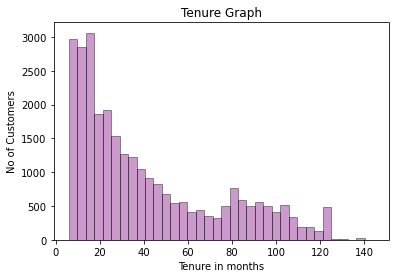

In [21]:
ax = sns.distplot(telecom_hv_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 10})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure in months')
ax.set_title('Tenure Graph')
# below graph simply shows the tenure of the customers

In [22]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_hv_cust['tenure_range'] = pd.cut(telecom_hv_cust['aon_mon'], tn_range, labels=tn_label)
telecom_hv_cust['tenure_range'].head()

7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
33        2-5 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

<AxesSubplot:>

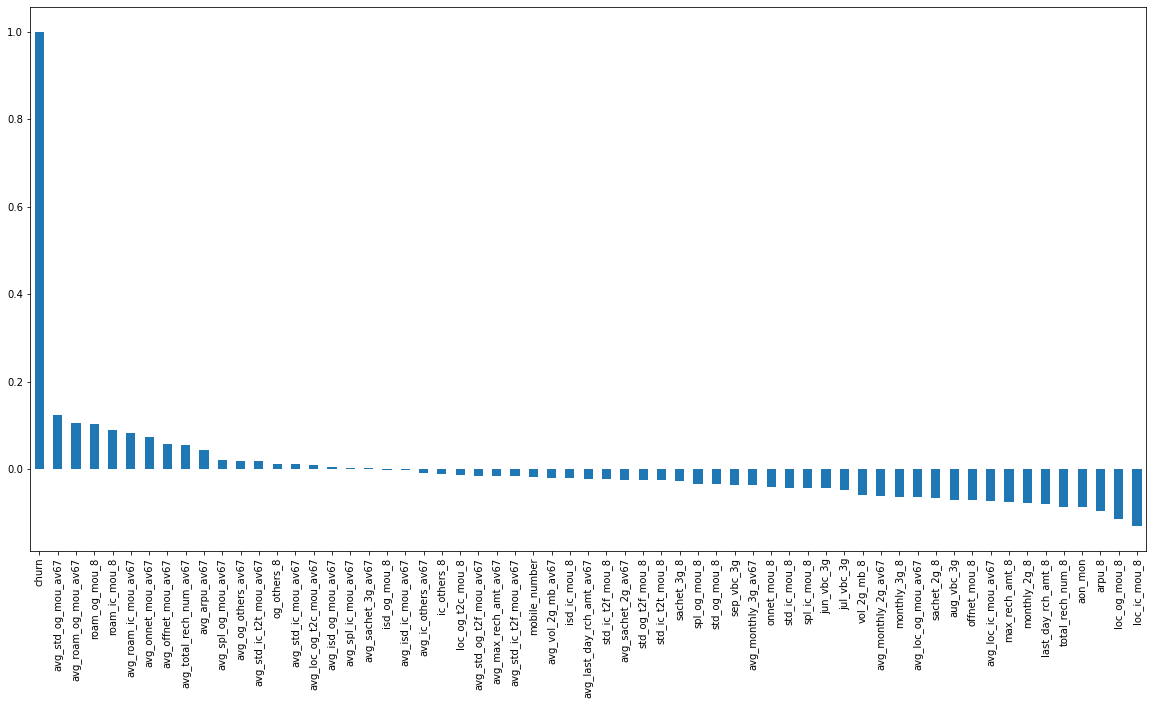

In [23]:
# lets check correlation of churn with other columns
plt.figure(figsize=(20,10))
telecom_hv_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

# observations : 
# 1. Avg Outgoing Calls & calls on romaning for 6 & 7th months are positively correlated with churn. 
# 2. Avg Revenue, No. Of Recharge for 8th month has negative correlation with churn.

<AxesSubplot:xlabel='total_rech_num_8', ylabel='arpu_8'>

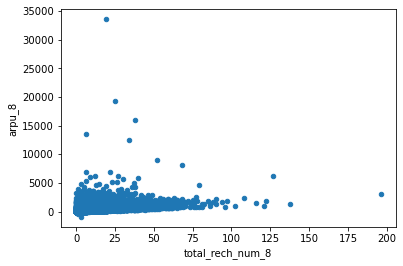

In [24]:
# lets now draw a scatter plot between total recharge and avg revenue for the 8th month
telecom_hv_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')

<AxesSubplot:xlabel='aon_mon', ylabel='avg_arpu_av67'>

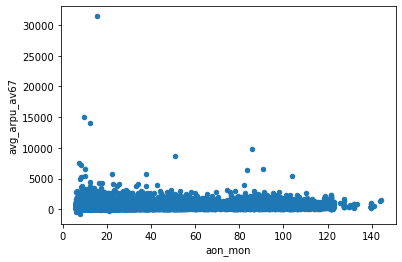

In [25]:
# plot between tenure and revenue
telecom_hv_cust[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon',
                                                              y='avg_arpu_av67')

# Churn Vs other important features

<AxesSubplot:xlabel='churn', ylabel='aon_mon'>

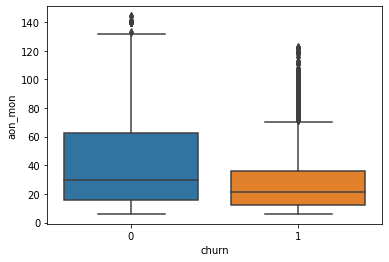

In [26]:
sns.boxplot(x = telecom_hv_cust.churn, y = telecom_hv_cust.aon_mon)

# from the below plot , its clear tenured customers do no churn and they keep availing telecom services

Text(0.5, 1.0, 'Churn Vs Base Cost')

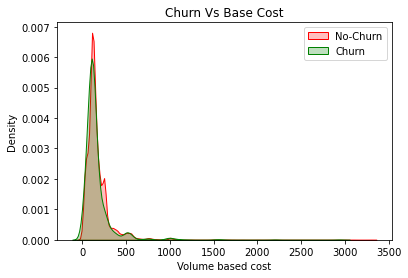

In [27]:
# churn Vs Base Cost
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Green", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Churn Vs Base Cost')

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

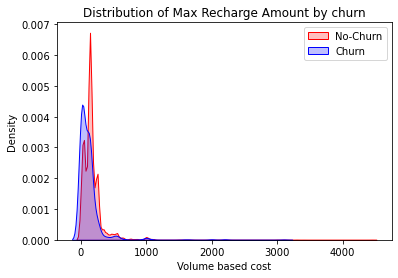

In [28]:
# churn vs max rechare amount
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

In [29]:
# we will create a new dataset for model building
df = telecom_hv_cust[:].copy()

# lets drop tenure range because it is highly correlated with AON MONTH column
df.drop('tenure_range', axis=1, inplace=True)
df.drop('mobile_number', axis=1, inplace=True)
df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,aon_mon
7,3171.480,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,...,15.465,5.0,1185.0,0.0,0.000,0.0,0.0,0.0,0.0,26.733333
8,137.362,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,...,0.000,20.0,122.0,25.0,178.000,0.5,0.5,0.0,0.0,10.500000
21,637.760,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,...,0.000,24.0,50.0,25.0,0.000,0.0,0.0,0.0,0.0,24.000000
23,366.966,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,...,2.675,4.0,89.5,89.5,0.240,0.0,0.0,1.0,0.0,20.133333
33,409.230,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,...,0.940,10.5,753.5,126.0,72.405,0.0,0.0,4.5,2.0,44.266667


# Train Test Split

In [30]:
# lets create X & y dataset for model building, X will obviously not have "churn" and y will only have "churn"
X = df.drop(['churn'], axis=1)
y = df['churn']

df.drop('churn', axis=1, inplace=True)


In [31]:
# apply scaling on the dataset
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [32]:
# split the dateset into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (19952, 59)
Dimension of X_test: (8552, 59)


In [33]:
# As discussed earlier, given dataset is skewed, lets balance the dataset
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)

In [34]:
print("Dimension of X_tr Shape:", X_tr.shape)
print("Dimension of y_tr Shape:", y_tr.shape)

print("Imbalance in Training dataset:",(y_tr != 0).sum()/(y_tr == 0).sum())

Dimension of X_tr Shape: (37666, 59)
Dimension of y_tr Shape: (37666,)
Imbalance in Training dataset: 1.0


In [35]:
# we will now using RFE for feature reduction
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.feature_selection import RFE

# lets RFE select 15 most imp features for us
rfe = RFE(lr)   
rfe = rfe.fit(X_tr, y_tr)

In [36]:
rfe_features = list(df.columns[rfe.support_])
print("15 most important features selected by RFE ", rfe_features)

15 most important features selected by RFE  ['onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'isd_og_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sep_vbc_3g', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67', 'avg_loc_og_mou_av67', 'avg_std_og_mou_av67', 'avg_isd_og_mou_av67', 'avg_loc_ic_mou_av67', 'avg_std_ic_mou_av67', 'avg_ic_others_av67', 'avg_total_rech_num_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'aon_mon']


In [37]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

In [38]:
# lets create a Logisctic Regression model on the seleted columns by RFE
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

LogisticRegression(random_state=1)

In [39]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print('Accuracy on the test dataset:',lr.score(X_test_rfe, y_test))

[[6479 1596]
 [  93  384]]
Accuracy on the test dataset: 0.8025023386342376


In [40]:
# lets check classification report on the test dataset
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      8075
           1       0.19      0.81      0.31       477

    accuracy                           0.80      8552
   macro avg       0.59      0.80      0.60      8552
weighted avg       0.94      0.80      0.85      8552



Conclusion from the above model:

Model Accuracy is approx 80%
Confusion matix shows high false positive rate, which is not good, lets try PCA now.

# PCA

In [41]:
# PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to correct class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)


(37666, 59)
(37666,)


In [42]:
# import PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

# apply PCA on train data
pca.fit(X_tr)

PCA(random_state=100)

In [43]:
X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(37666, 59)
(8552, 59)


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_tr_pca, y_tr)

# make the predictions
y_pred = lr_pca.predict(X_test_pca)

# convert prediction array into a dataframe
y_pred_df = pd.DataFrame(y_pred)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))
print("Accuracy of the logistic regression model with PCA: ",accuracy_score(y_test,y_pred))

[[6497 1578]
 [  97  380]]
Accuracy of the logistic regression model with PCA:  0.8041393826005613


In [46]:
col = list(df.columns)
df_pca = pd.DataFrame({'PC-1':pca.components_[0],'PC-2':pca.components_[1], 'PC-3':pca.components_[2],'Feature':col})
df_pca.head(10)

,PC-1,PC-2,PC-3,Feature
0,0.155921,0.269145,0.140473,arpu_8
1,0.057037,0.207173,-0.091049,onnet_mou_8
2,0.101735,0.239552,-0.000097,offnet_mou_8
3,0.434714,-0.176010,-0.053388,roam_ic_mou_8
4,0.374939,-0.073459,-0.067725,roam_og_mou_8
5,0.012619,0.072643,-0.039023,loc_og_t2c_mou_8
6,0.021843,0.158794,0.147662,loc_og_mou_8
7,0.024505,0.039378,0.079571,std_og_t2f_mou_8
8,0.042611,0.252677,-0.150593,std_og_mou_8
9,0.038924,0.099163,0.087010,isd_og_mou_8


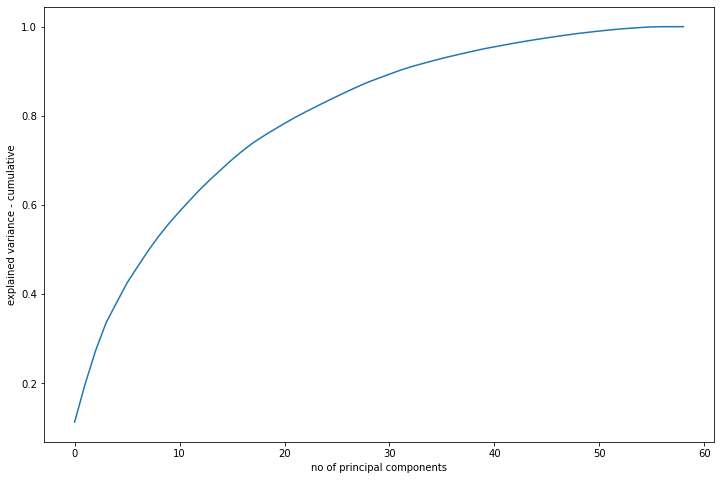

In [47]:
# scree plot to check the variance explained by different PCAs
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no of principal components')
plt.ylabel('explained variance - cumulative')
plt.show()

In [48]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
# 33 columns explains 90% of the variance, lets apply PCA with 33 components

array([ 11.32,  19.84,  27.37,  33.6 ,  38.11,  42.54,  46.16,  49.72,
        52.98,  55.91,  58.58,  61.14,  63.63,  65.91,  68.08,  70.21,
        72.17,  73.96,  75.49,  76.93,  78.32,  79.65,  80.89,  82.08,
        83.25,  84.39,  85.51,  86.6 ,  87.61,  88.49,  89.36,  90.22,
        90.99,  91.64,  92.28,  92.9 ,  93.46,  94.  ,  94.53,  95.05,
        95.49,  95.93,  96.36,  96.76,  97.14,  97.5 ,  97.85,  98.18,
        98.5 ,  98.77,  99.03,  99.27,  99.49,  99.66,  99.82,  99.95,
       100.  , 100.  , 100.  ])

In [49]:
# PCA with 33 components
pca_33 = PCA(n_components=33)

df_tr_pca_33 = pca_33.fit_transform(X_tr)
print(df_tr_pca_33.shape)

df_test_pca_33 = pca_33.transform(X_test)
print(df_test_pca_33.shape)

(37666, 33)
(8552, 33)


In [50]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_33, y_tr)

# Predicted probabilities
y_pred33 = lr_pca1.predict(df_test_pca_33)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred33)

print("Accuracy with 33 PCAs: ",accuracy_score(y_test,y_pred33))

Accuracy with 33 PCAs:  0.8008652946679139


In [51]:
print(confusion_matrix(y_test,y_pred33))

[[6477 1598]
 [ 105  372]]


Conclusions from the above model:

Model has 80% Accuracy
33 features can explain 90% variance in the dataset
most imp features: arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8

# Class Imbalance

In [52]:
# lets create a decision tree now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to tackle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(37666, 59)
(37666,)


# Decision Tree

In [53]:
# import decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# lets create a decision tree with the default hyper parameters except max depth to make the tree readable
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_tr, y_tr)

DecisionTreeClassifier(max_depth=5)

In [54]:
# lets see the classification reort of the model built
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model predictions
X_test = pd.DataFrame(data=X_test)
y_pred1 = dt1.predict(X_test)

# classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91      8075
           1       0.22      0.69      0.34       477

    accuracy                           0.85      8552
   macro avg       0.60      0.78      0.63      8552
weighted avg       0.94      0.85      0.88      8552



In [55]:
# confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of the decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1))

[[6915 1160]
 [ 146  331]]
Decision Tree - Accuracy : 0.8472871842843779


# Hyperparameters Tuning

In [56]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                    n_jobs = -1,
                   return_train_score=True)
tree.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             n_jobs=-1, param_grid={'max_depth': range(1, 40)},
             return_train_score=True, scoring='accuracy')

In [57]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.650020,0.061483,0.011569,0.003253,1,{'max_depth': 1},0.771436,0.791849,0.806452,0.804460,...,0.795227,0.012913,39,0.801175,0.796104,0.792453,0.792951,0.793582,0.795253,0.003216
1,1.077366,0.038788,0.009236,0.005892,2,{'max_depth': 2},0.808468,0.817204,0.824904,0.828488,...,0.820767,0.007165,38,0.829384,0.824113,0.820960,0.821060,0.820629,0.823229,0.003325
2,1.301967,0.073212,0.009374,0.007654,3,{'max_depth': 3},0.816830,0.833931,0.848268,0.850790,...,0.839511,0.012784,37,0.844418,0.845883,0.838383,0.841635,0.842133,0.842491,0.002567
3,1.571143,0.097811,0.010053,0.003545,4,{'max_depth': 4},0.831431,0.844949,0.864065,0.865127,...,0.853131,0.013035,36,0.856730,0.860021,0.855673,0.855175,0.853947,0.856309,0.002060
4,2.027071,0.047051,0.006248,0.007652,5,{'max_depth': 5},0.841386,0.854241,0.875083,0.877074,...,0.862688,0.013376,35,0.871399,0.869280,0.869047,0.866857,0.861016,0.867520,0.003556


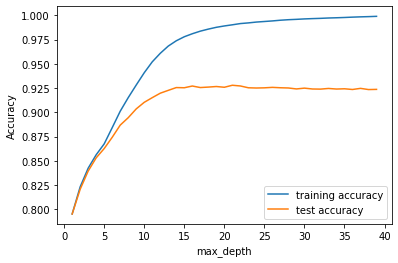

In [58]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# max_depth =10 seems to be the optimal one

In [59]:
# lets find optimal value of minimum sample leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [60]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.920092,0.045099,0.015617,0.000006,5,{'min_samples_leaf': 5},0.880807,0.920881,0.927519,0.930439,...,0.915920,0.017995,1,0.972455,0.968374,0.969104,0.969236,0.968374,0.969508,0.001516
1,1.547089,0.055058,0.003122,0.006244,25,{'min_samples_leaf': 25},0.866737,0.891544,0.912917,0.908270,...,0.896220,0.016397,2,0.928216,0.922842,0.922377,0.921316,0.922178,0.923386,0.002465
2,1.540172,0.196723,0.003124,0.006249,45,{'min_samples_leaf': 45},0.857181,0.885172,0.899509,0.898580,...,0.886742,0.015634,3,0.912618,0.905784,0.905054,0.904025,0.904756,0.906448,0.003136
3,1.393308,0.105873,0.012496,0.006248,65,{'min_samples_leaf': 65},0.848553,0.878003,0.889951,0.892871,...,0.880264,0.016732,4,0.902761,0.895331,0.891913,0.896890,0.898351,0.897049,0.003569
4,1.783091,0.279369,0.003124,0.006249,85,{'min_samples_leaf': 85},0.843642,0.871366,0.885437,0.890615,...,0.875326,0.017091,5,0.894166,0.889158,0.884910,0.889258,0.889357,0.889370,0.002931


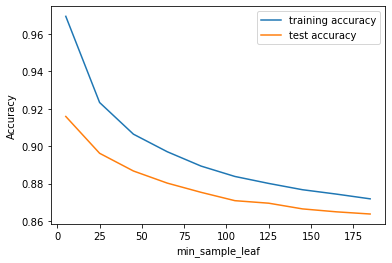

In [61]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# min_sample_leaf =25 seems to be the optimal one

In [62]:
# lets fine tune min sample split now
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                    n_jobs = -1,
                   return_train_score=True)
tree.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             n_jobs=-1, param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [63]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.351426,0.157485,0.012497,0.006248,5,{'min_samples_split': 5},0.895938,0.927917,0.932962,0.932298,...,0.923353,0.013880,1,0.995785,0.994757,0.995553,0.994956,0.994856,0.995181,0.000410
1,6.368628,0.203985,0.013948,0.007518,25,{'min_samples_split': 25},0.885984,0.915571,0.920616,0.924598,...,0.913743,0.014186,2,0.971625,0.967677,0.966913,0.968838,0.969303,0.968871,0.001614
2,6.401629,0.153504,0.012497,0.006249,45,{'min_samples_split': 45},0.876958,0.905615,0.914377,0.918625,...,0.905698,0.014970,3,0.956591,0.950353,0.950718,0.953539,0.950951,0.952431,0.002365
3,6.345532,0.163318,0.012506,0.006253,65,{'min_samples_split': 65},0.874170,0.902960,0.911191,0.914111,...,0.901875,0.014359,4,0.944677,0.940796,0.940663,0.941559,0.942090,0.941957,0.001456
4,6.305159,0.156607,0.012496,0.011689,85,{'min_samples_split': 85},0.867401,0.897783,0.908005,0.908270,...,0.897468,0.015509,5,0.937376,0.933362,0.933462,0.930674,0.934490,0.933873,0.002159


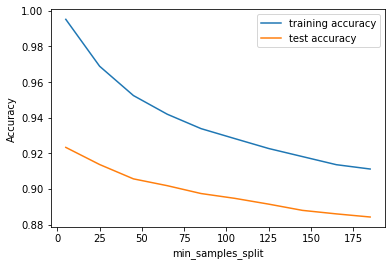

In [64]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# min_samples_leaf=50 seems to be optimal

In [65]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds,n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_tr, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(25, 175, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [66]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)


Best Accuracy 0.8951315776815092


In [67]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50)


In [68]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_tr, y_tr)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=25, min_samples_split=50,
                       random_state=100)

In [69]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Accuracy Score for Decision Tree Final Model : 0.8465855940130963


In [70]:
# Conclusion from the above Decision Tree model
# 1. 84% accuracy on the test dataset
# 2. lots of false positives in the confusion matrix

# Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_tr, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(y_test, prediction_test))

Randon Forest Accuracy with Default Hyperparameter 0.9422357343311506


In [72]:
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8075
           1       0.48      0.55      0.52       477

    accuracy                           0.94      8552
   macro avg       0.73      0.76      0.74      8552
weighted avg       0.95      0.94      0.94      8552



In [73]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[7794  281]
 [ 213  264]]


In [74]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",n_jobs = -1,
                  return_train_score=True)
rf.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

In [75]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.882923,0.042610,0.174959,0.006248,2,{'max_depth': 2},0.822803,0.843356,0.859684,0.851586,...,0.847635,0.013911,4,0.849462,0.851923,0.847543,0.839943,0.849998,0.847774,0.004157
1,18.922935,0.140865,0.224946,0.007654,7,{'max_depth': 7},0.878152,0.891809,0.907341,0.906943,...,0.898105,0.011558,3,0.914609,0.909136,0.903793,0.904025,0.906183,0.907549,0.004019
2,27.676711,0.272106,0.284387,0.011774,12,{'max_depth': 12},0.931776,0.948759,0.954202,0.958051,...,0.950380,0.009985,2,0.977532,0.974546,0.973982,0.973418,0.973418,0.974579,0.001535
3,27.199520,2.833544,0.209390,0.040339,17,{'max_depth': 17},0.946907,0.965220,0.970264,0.971061,...,0.965009,0.009330,1,0.991139,0.990243,0.989779,0.990608,0.989745,0.990303,0.000526


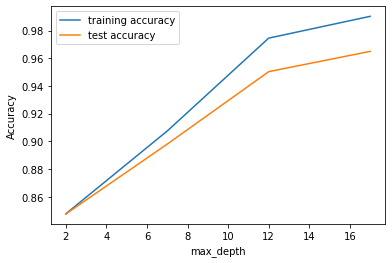

In [76]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [77]:
##Tuning n_estimators
## GridSearchCV to find optimal n_estimators
#from sklearn.model_selection import KFold
## specify number of folds for k-fold CV
n_folds = 5
#
## parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}
#
## instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)
#
#
## fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,n_jobs = -1, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=4), n_jobs=-1,
             param_grid={'n_estimators': range(100, 1500, 400)},
             return_train_score=True, scoring='accuracy')

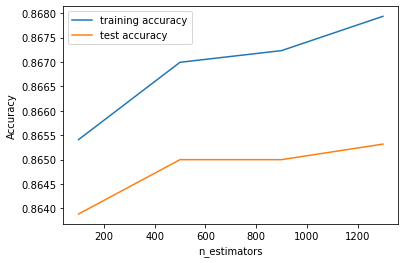

In [78]:
## scores of GridSearch CV
scores = rf.cv_results_
#
## plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [79]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(30, 120, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",n_jobs = -1,
                  return_train_score=True)
rf.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': range(30, 120, 10)},
             return_train_score=True, scoring='accuracy')

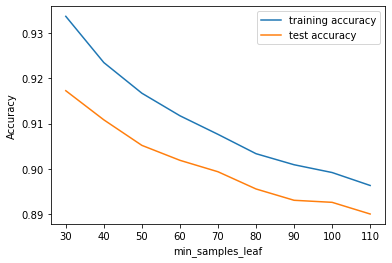

In [80]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [81]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 300, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",n_jobs = -1,
                   return_train_score=True)
rf.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_split': range(100, 300, 25)},
             return_train_score=True, scoring='accuracy')

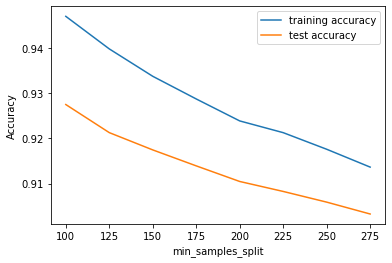

In [82]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [83]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# fit the grid search with the data
grid_search.fit(X_tr, y_tr)
# optimal accuracy score and hyperparameters
print('Accuracy is',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [ ]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

In [ ]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))

In [ ]:
# list of important features
X = df
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

### Conclusion 

Random Forest

1. Local Incoming for Month 8, Average Revenue Per Customer for Month 8 and Max Recharge Amount for Month 8 are the most important predictor variables to predict churn.

# Conclusion

1. `Std Outgoing Calls` and `Revenue Per Customer` are strong indicators of Churn.
2. `Local Incoming` and `Outgoing Calls` for 8th Month and `Avg revenue` in 8th Month are the most important columns to predict churn.
3. cutomers with tenure less than 4 yrs are more likely to churn.
4. `Max Recharge Amount` is a strong feature to predict churn.
6. Random Forest produced the best prediction results followed by SVM.
